In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyeit.eit.protocol as protocol
import pyeit.mesh as mesh
import seaborn as sns
import tensorflow as tf
from pyeit.eit.fem import EITForward
from pyeit.mesh import PyEITMesh

### Libraries for simulation
## from pyeit.mesh.shape import thorax
from pyeit.mesh.wrapper import PyEITAnomaly_Circle
from sciopy import plot_mesh
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tqdm import tqdm

from manipulate_mesh import move_el, set_perm_circle, set_sqr_perm

2023-09-15 12:46:31.626792: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 12:46:31.763239: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 12:46:31.764134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 12:46:32.552338: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def _normalize(data: np.ndarray) -> np.ndarray:
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [3]:
r_bone = 0.2

X_veit = list()
y_dcart = list()

# perm_bone = list()

for ele in os.listdir("data/"):
    tmp = np.load(f"data/{ele}", allow_pickle=True)

    cart_d = float(tmp["params"].tolist().split(",")[2].split("=")[1]) - r_bone
    X_veit.append(_normalize(tmp["v_obj"]))
    y_dcart.append(np.round(cart_d, 3))
#    perm_bone.append(float(tmp["params"].tolist().split(",")[0].split("=")[1]))

X_veit = np.array(X_veit)
y_dcart = np.array(y_dcart)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_veit, y_dcart, test_size=0.2, shuffle=True
)

In [29]:
input_shape = (192,)
output_shape = (1,)

model = tf.keras.Sequential()

model.add(Input(shape=input_shape))

model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(1, activation="linear"))

model.compile(optimizer="adam", loss="mean_squared_error")

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               24704     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                 9         
                                                                 
Total params: 35713 (139.50 KB)
Trainable params: 3571

In [30]:
model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/50
125/125 [==============================] - 1s 1ms/step - loss: 0.0093
Epoch 2/50
125/125 [==============================] - 0s 1ms/step - loss: 0.0072
Epoch 3/50
125/125 [==============================] - 0s 1ms/step - loss: 0.0062
Epoch 4/50
125/125 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 5/50
125/125 [==============================] - 0s 1ms/step - loss: 1.7339e-04
Epoch 6/50
125/125 [==============================] - 0s 1ms/step - loss: 1.5342e-04
Epoch 7/50
125/125 [==============================] - 0s 1ms/step - loss: 1.6467e-04
Epoch 8/50
125/125 [==============================] - 0s 1ms/step - loss: 1.9523e-04
Epoch 9/50
125/125 [==============================] - 0s 1ms/step - loss: 1.7120e-04
Epoch 10/50
125/125 [==============================] - 0s 1ms/step - loss: 1.5239e-04
Epoch 11/50
125/125 [==============================] - 0s 1ms/step - loss: 1.5418e-04
Epoch 12/50
125/125 [==============================] - 0s 1ms/step - loss: 1.47

In [31]:
predictions = model.predict(X_valid)

63/63 [==============================] - 0s 711us/step


In [36]:
df = {"predictions - y_valid": np.concatenate(predictions - y_valid)}

In [37]:
hrdf = pd.DataFrame(data=df)

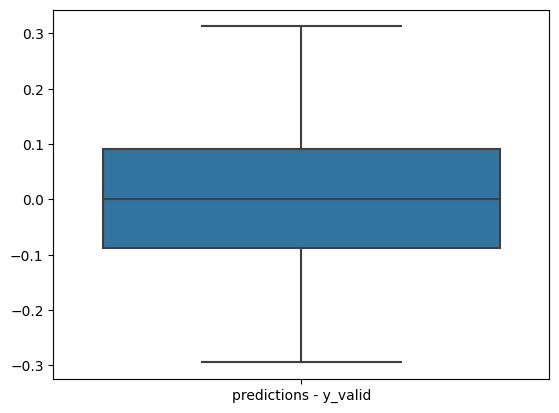

In [38]:
sns.boxplot(data=hrdf)
plt.show()

# Comparison of the cartilage impact

In [26]:
h0 = 0.05
n_el = 16
dist_exc = 8
step_meas = 1

mesh_empty = mesh.create(n_el, h0=h0)
mesh_obj = mesh.create(n_el, h0=h0)

# change electrode positions
el_posis = [(0.2, 0), (0, -0.2), (-0.2, 0.0), (0, 0.2)]
lst = [0, 4, 8, 12]

mesh_empty = move_el(mesh_empty, el_idx=lst, target_x_y=el_posis)
mesh_obj = move_el(mesh_obj, el_idx=lst, target_x_y=el_posis)
el_pos = mesh_empty.el_pos

eukl_dict = {}

for r_cart in np.linspace(0.2,0.9):
    anomaly_cartilage = PyEITAnomaly_Circle(center=[0, 0], r=r_cart, perm=25)
    anomaly_bone = PyEITAnomaly_Circle(center=[0, 0], r=0.2, perm=50)

    mesh_empty = mesh.set_perm(mesh_empty, anomaly=anomaly_bone, background=1.0)
    mesh_obj = mesh.set_perm(mesh_obj, anomaly=anomaly_cartilage, background=1.0)
    mesh_obj = set_perm_circle(mesh_obj, anomaly=anomaly_bone)

    protocol_obj = protocol.create(
        n_el, dist_exc=dist_exc, step_meas=step_meas, parser_meas="std"
    )

    fwd_v = EITForward(mesh_empty, protocol_obj)
    v_empty = fwd_v.solve_eit(perm=mesh_empty.perm)
    v_obj = fwd_v.solve_eit(perm=mesh_obj.perm)
    eukl_dict[r_cart]= np.linalg.norm(v_empty-v_obj)

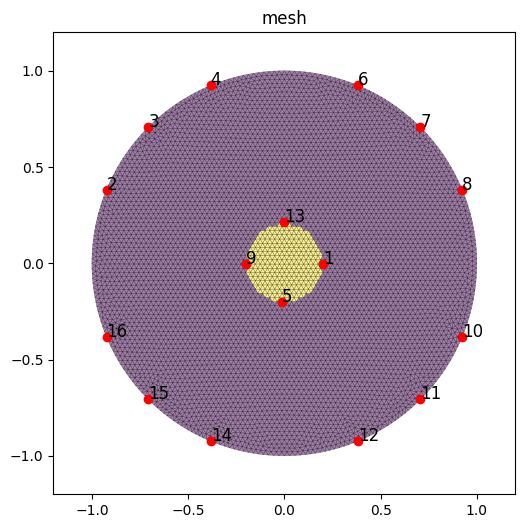

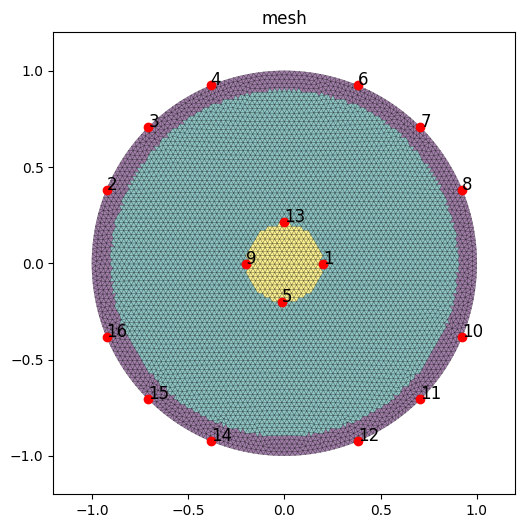

In [27]:
plot_mesh(mesh_empty)
plot_mesh(mesh_obj)

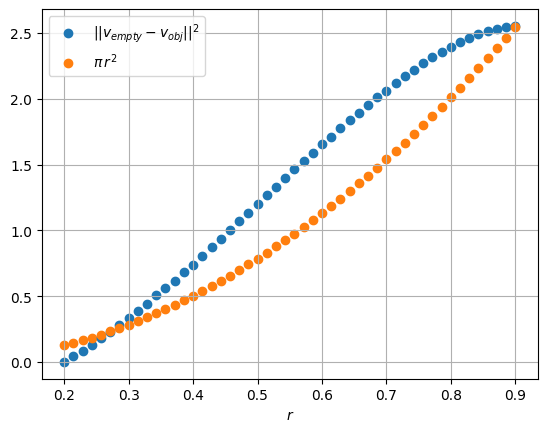

In [30]:
for r, val in zip(eukl_dict.keys(), eukl_dict.values()):
    plt.scatter(r,val ,c="C0")
    plt.scatter(r,np.pi*r**2, c="C1")
plt.grid()
plt.xlabel("$r$")
plt.legend(["$||v_{empty}-v_{obj}||^2$","$\pi \, r^2$"])
plt.show()


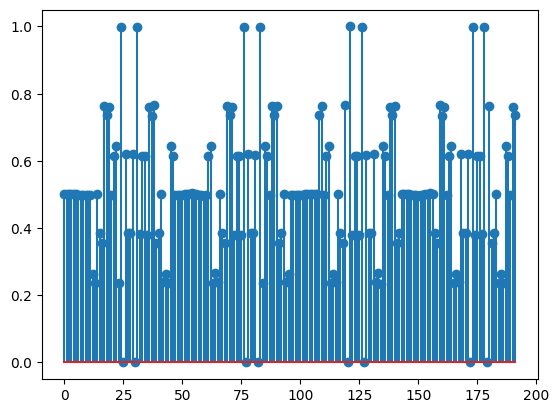

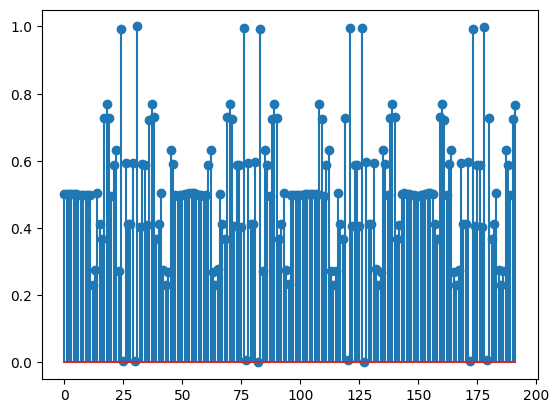

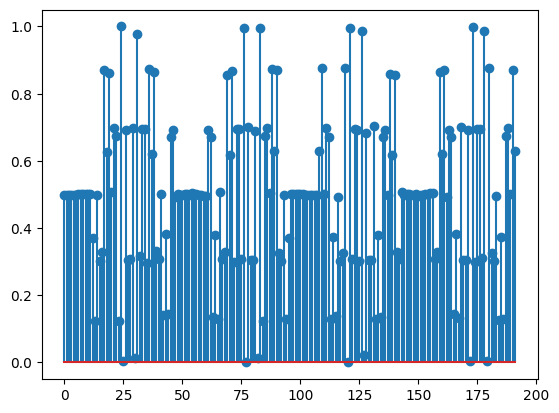

In [6]:
plt.stem(_normalize(v_empty))
plt.show()

plt.stem(_normalize(v_obj))
plt.show()

plt.stem(_normalize(v_empty-v_obj))
plt.show()

In [7]:
np.linalg.norm(v_empty-v_obj)

0.7497818663877347